# import

In [1]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import os
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import dot
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# find session with good trace

In [2]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_mat_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


In [3]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

# print(df_tidy.mouse.unique(), 
#       df_tidy.date.unique(), 
#       df_tidy.sess.unique(), 
#       df_tidy.area.unique(), 
#       df_tidy.isi.unique(), 
#       df_tidy.stim1_contrast.unique(), 
#       df_tidy.stim2_id.unique(), 
#       df_tidy.resp_id.unique())
# df_tidy.sample(5, random_state=0)

In [4]:
df_tidy['datesess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)
df_tidy[(df_tidy.area == 'LM') & (df_tidy.filter_cell_vis == True)].groupby('datesess').filter_cell_well_fit.sum().sort_values(ascending=False).head()
# df_tidy[(df_tidy.area == 'V1') & (df_tidy.filter_cell_vis == True)].groupby('datesess').filter_cell_well_fit.sum().sort_values(ascending=False).head()

datesess
230302_003    71820.0
230302_004    38962.0
210127_002    26826.0
201217_002    20488.0
210805_002    14953.0
Name: filter_cell_well_fit, dtype: float64

In [5]:
select_datesess = '230302_003    '.strip()
df_now = df_tidy[df_tidy.datesess == select_datesess]
area_imouse_date_sess = df_now.area.unique()[0] + '_i' + df_now.mouse.unique()[0] + '_' + select_datesess
area_imouse_date_sess

'LM_i1373_230302_003'

# load session

In [6]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')

try:
    trace = sio.loadmat(dir_sess_trace)
except:
    area_imouse_date_sess = area_imouse_date_sess + '_cellpose'
    dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
    trace = sio.loadmat(dir_sess_trace)
trace_by_trial = trace['trace_by_trial']
ncell = trace_by_trial.shape[0]
ntrial = trace_by_trial.shape[1]
nframe = trace_by_trial.shape[2]

print(f'ncell={ncell}, ntrial={ntrial}, nframe={nframe}')

ncell=139, ntrial=502, nframe=207


## find cells with large adp and R2

In [7]:
R2 = (df_tidy[(df_tidy.datesess == select_datesess) 
        & (df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_fit == True) 
        & (df_tidy.stim2_id == 0)
        & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R2'}))

R1 = (df_tidy[(df_tidy.datesess == select_datesess) 
        & (df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_fit == True) 
        & (df_tidy.stim2_id == 0)
        & ( 
           ((df_tidy.isi == 6000) & (df_tidy.resp_id == 'R2')) | 
           (df_tidy.resp_id == 'R1') )
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R1'}))

df_adp = pd.merge(R1, R2, on='cell_id')
df_adp['adp'] = (df_adp.R2 - df_adp.R1) / (df_adp.R1 + 1e-7)
df_adp = df_adp[(df_adp.R1 > 0) & (df_adp.R2 > 0.05)].sort_values('adp', ascending=True).reset_index(drop=True)
df_adp.head(10)

,cell_id,R1,R2,adp
0,230302_003_128,0.719837,0.295017,-0.590161
1,230302_003_81,0.304889,0.135118,-0.556830
2,230302_003_31,0.122934,0.054708,-0.554980
3,230302_003_70,0.143168,0.070537,-0.507312
4,230302_003_108,0.396317,0.208138,-0.474820
5,230302_003_127,0.179214,0.096002,-0.464317
6,230302_003_87,0.120051,0.075011,-0.375177
7,230302_003_58,0.129303,0.086960,-0.327471
8,230302_003_82,0.211765,0.145759,-0.311697
9,230302_003_89,0.212922,0.156721,-0.263952


In [8]:
## select example cells

cell_id = df_adp.head(10).cell_id.values
cell_id = [item.split('_')[-1] for item in cell_id]
cell_id = [int(item) for item in cell_id]
cell_id

[128, 81, 31, 70, 108, 127, 87, 58, 82, 89]

In [9]:
## select example trials (stim2 = 0, isi = 250, resp_id = R2)

trial_id = df_tidy[(df_tidy.datesess == select_datesess) 
            & (df_tidy.stim2_id == 0)
            & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
            ].trial_id.unique()
trial_id

array([  8,  41,  47, 104, 105, 140, 167, 188, 189, 214, 251, 269, 293,
       304, 328, 329, 340, 345, 372, 416, 426, 439, 450, 454, 482, 494],
      dtype=int64)

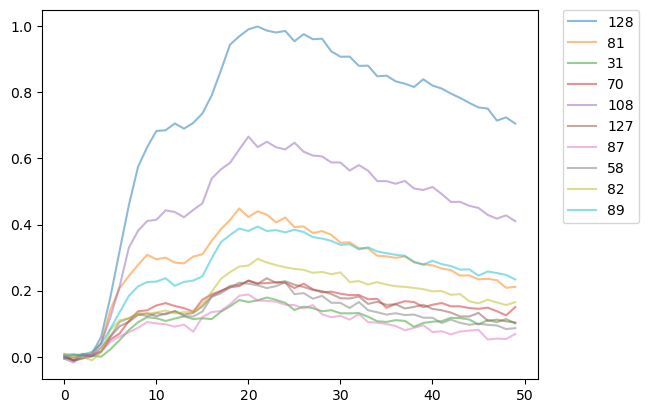

In [10]:
## choose cell by nice avg trace 

for icell in cell_id:
    trace_avg_cell = trace_by_trial[icell, trial_id, :50].mean(axis=0)
    plt.plot(trace_avg_cell, alpha=0.5);
plt.legend(cell_id, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

## single cell single trial trace

In [29]:
ylim_lower = trace_by_trial[cell_id_example, :, :50]
ylim_lower = ylim_lower[:, trial_id, :50].min() - 0.01
ylim_lower

-0.16921419719094966

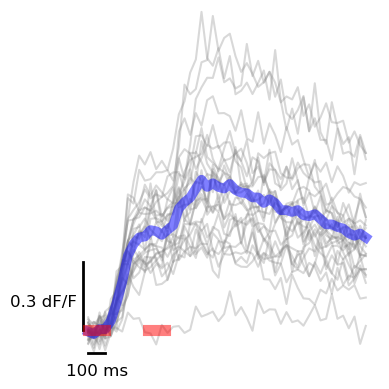

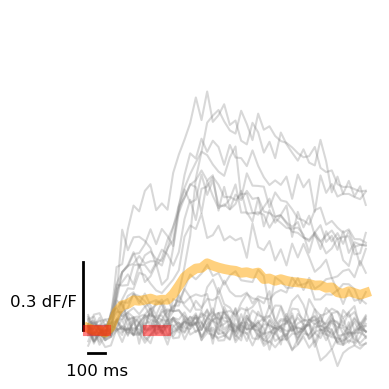

In [31]:
cell_id_example = [108, 82]
ylim_lower = trace_by_trial[cell_id_example, :, :50]
ylim_lower = ylim_lower[:, trial_id, :50].min() - 0.01
ylim_upper = trace_by_trial[cell_id_example, :, :50]
ylim_upper = ylim_upper[:, trial_id, :50].max() + 0.01
color_arr = ['blue', 'orange']

for icell, single_cell_id in enumerate(cell_id_example):
    plt.figure(figsize=(4, 4))

    for itrial in trial_id:
        trace_trial = trace_by_trial[single_cell_id, itrial, :50]
        plt.plot(trace_trial, alpha=0.3, color='gray');

    trace_agg_cell = trace_by_trial[single_cell_id, trial_id, :50].mean(axis=0)
    plt.plot(trace_agg_cell, alpha=0.5, linewidth=7, color=color_arr[icell]);

    ## vertical scale bar at x=-2, y=[0, 0.25]
    plt.plot([-1, -1], [0, 0.3], linewidth=2, color='k');
    ## text on the left of the scale bar
    plt.text(-2, 0.125, '0.3 dF/F', ha='right', va='center', fontsize=12);

    ## horizontal scale bar at x=[0, 30], y=0
    plt.plot([0, 3], [-0.1, -0.1], linewidth=2, color='k');
    ## text on the bottom of the scale bar
    plt.text(1.5, -0.15, '100 ms', ha='center', va='top', fontsize=12);

    ## stim onset and offset
    frame_shift = 0
    frame_rate = 30
    stim1_sec = 0.100
    isi_sec = 0.250
    stim2_sec = 0.100
    stim1_time = np.arange(0 + frame_shift, 
                        frame_rate * stim1_sec + frame_shift, 
                        0.01)
    stim2_time = np.arange(frame_rate * (stim1_sec + isi_sec) + frame_shift, 
                        frame_rate * (stim1_sec + isi_sec + stim2_sec) + frame_shift, 
                        0.01)
    y = np.ones(stim1_time.shape) * 0
    plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5) # plot stim onset time
    plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5);

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([]);
    plt.ylim(ylim_lower, ylim_upper);
    plt.tight_layout();

    dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
    plt.savefig(dir_fig + f'fig1_example_single_vis_cell_single_trial_trace_{single_cell_id}_{area_imouse_date_sess}.pdf')

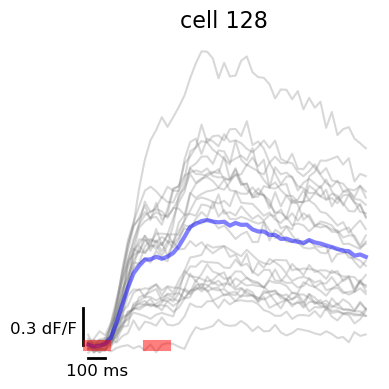

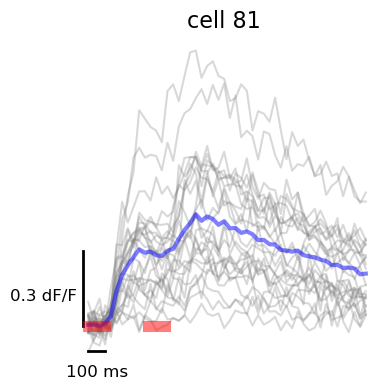

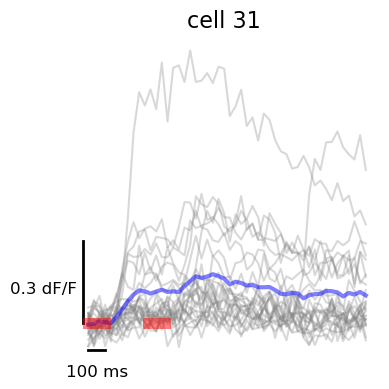

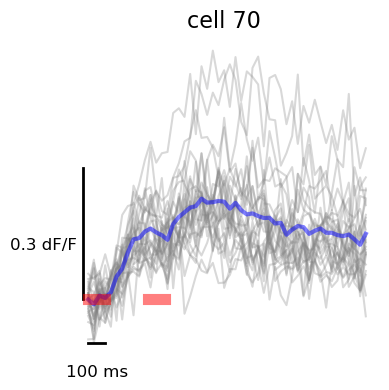

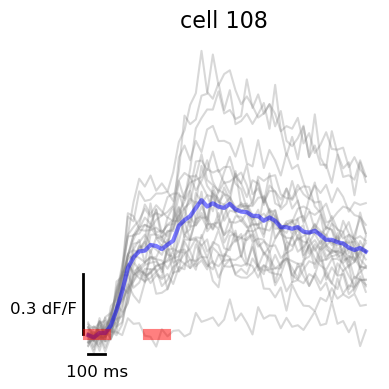

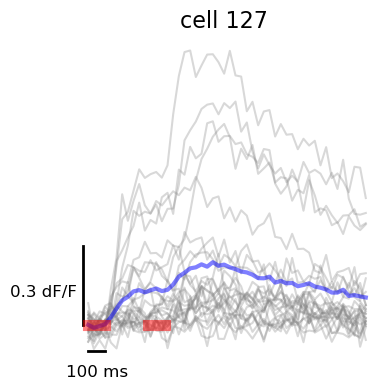

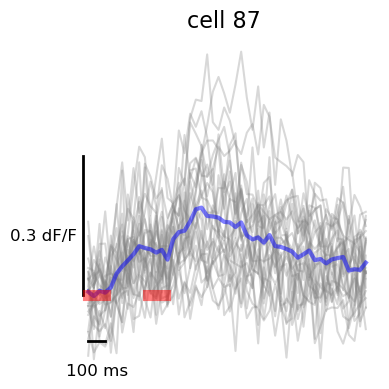

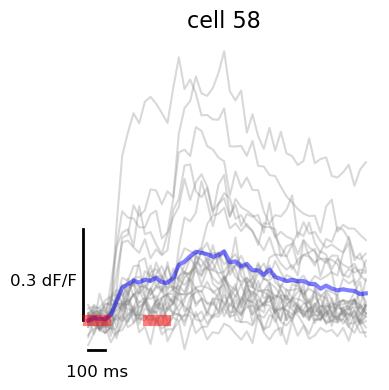

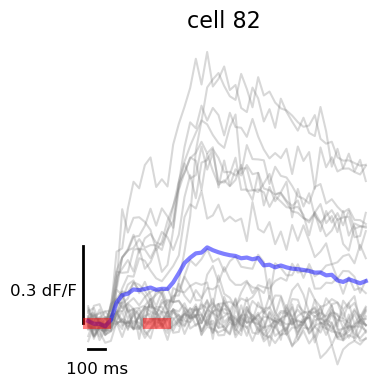

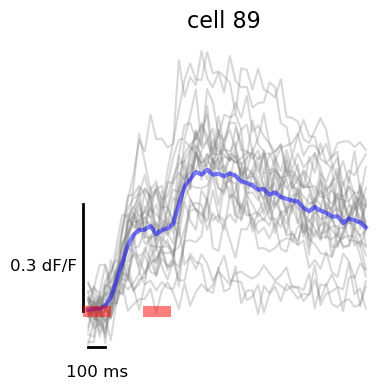

In [12]:
for single_cell_id in cell_id:
    plt.figure(figsize=(4, 4))

    # ylim_upper = 1.3
    ylim_lower = trace_by_trial[single_cell_id, trial_id, :50].min() - 0.01

    for itrial in trial_id:
        trace_trial = trace_by_trial[single_cell_id, itrial, :50]
        plt.plot(trace_trial, alpha=0.3, color='gray');
        # if trace_trial.max() <= ylim_upper:
        #     plt.plot(trace_trial, alpha=0.3, color='gray');
        # else:
        #     print(f'itrial={itrial}, max={round(trace_trial.max(), 2)}')

    trace_agg_cell = trace_by_trial[single_cell_id, trial_id, :50].mean(axis=0)
    # trace_agg_cell = np.median(trace_by_trial[single_cell_id, trial_id, :50], axis=0)
    plt.plot(trace_agg_cell, alpha=0.5, linewidth=3, color='blue');

    # plt.ylim(ylim_lower, ylim_upper);
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([]);

    ## vertical scale bar at x=-2, y=[0, 0.25]
    plt.plot([-1, -1], [0, 0.3], linewidth=2, color='k');
    ## text on the left of the scale bar
    plt.text(-2, 0.125, '0.3 dF/F', ha='right', va='center', fontsize=12);

    ## horizontal scale bar at x=[0, 30], y=0
    plt.plot([0, 3], [-0.1, -0.1], linewidth=2, color='k');
    ## text on the bottom of the scale bar
    plt.text(1.5, -0.15, '100 ms', ha='center', va='top', fontsize=12);

    frame_shift = 0
    frame_rate = 30
    stim1_sec = 0.100
    isi_sec = 0.250
    stim2_sec = 0.100

    stim1_time = np.arange(0 + frame_shift, 
                        frame_rate * stim1_sec + frame_shift, 
                        0.01)
    stim2_time = np.arange(frame_rate * (stim1_sec + isi_sec) + frame_shift, 
                        frame_rate * (stim1_sec + isi_sec + stim2_sec) + frame_shift, 
                        0.01)
    y = np.ones(stim1_time.shape) * 0
    plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5) # plot stim onset time
    plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5);

    plt.title(f'cell {single_cell_id}', fontsize=16);
    plt.tight_layout();

    dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
    # plt.savefig(dir_fig + r'fig1_example_single_vis_cell_single_trial_trace.pdf')